In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
from jax import grad, jit

In [2]:
_eps = np.exp(-16) # small number (from the script) to avoid division by zero

def log(x):
    return np.log(x + _eps)

def softmax(x):
    """
    Compute the softmax of a vector x. Will compute column-wise softmax if x is a 2-D matrix.
    """
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [3]:
# shapes by column ['square', 'circle', 'triangle']

# output given states/shapes matrices 
light_blue_shapes_os = np.asarray([
    [9/10, 5/100, 5/100],
    [5/100, 9/10, 5/100],
    [5/100, 5/100, 9/10]
])

light_green_shapes_os = np.asarray([
    [1/3, 1/3, 1/3],
    [1/3, 1/3, 1/3],
    [1/3, 1/3, 1/3]
])

In [4]:
# transition matrices for shapes
light_blue_shapes_ts = np.asarray([
    [3/10, 3/10, 5/10],
    [0, 3/10, 5/10],
    [7/10, 4/10, 0]
])

light_green_shapes_ts = np.asarray([
    [5/10, 3/10, 1],
    [0, 7/10, 0],
    [5/10, 0, 0]
])

In [5]:
# priors for starting states/shapes
light_blue_shapes_ps = np.asarray([0, 0, 1])

light_green_shapes_ps = np.asarray([1, 0, 0])

In [6]:
# output of state indices
light_blue_shapes_true_posterior = [2, 1, 0, 2, 1, 0, 0, 2, 1, 2, 0, 2, 1, 1, 2]

light_green_shapes_true_posterior = [0, 0, 2, 0, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 0]

out_indices = [2, 0, 0, 0, 1, 0, 0, 2, 2, 0, 0, 2, 1, 1, 2]


outs = np.zeros((len(out_indices), 3))
for i, idx in enumerate(out_indices):
    outs[i, idx] = 1

In [7]:
# for bs, o in zip(light_blue_shapes_true_posterior, out_indices):
#     print(light_blue_shapes_os[bs][o])
#     print(light_blue_shapes_ts[bs])
#     print()

In [8]:
for i, true_state_i in enumerate(light_blue_shapes_true_posterior):
    print(light_blue_shapes_os[:, true_state_i])
    if i < len(light_blue_shapes_true_posterior) - 1:
        # print(light_blue_shapes_ts[true_state_i])
        print(light_blue_shapes_ts[:, true_state_i])
    print()

[0.05 0.05 0.9 ]
[0.5 0.5 0. ]

[0.05 0.9  0.05]
[0.3 0.3 0.4]

[0.9  0.05 0.05]
[0.3 0.  0.7]

[0.05 0.05 0.9 ]
[0.5 0.5 0. ]

[0.05 0.9  0.05]
[0.3 0.3 0.4]

[0.9  0.05 0.05]
[0.3 0.  0.7]

[0.9  0.05 0.05]
[0.3 0.  0.7]

[0.05 0.05 0.9 ]
[0.5 0.5 0. ]

[0.05 0.9  0.05]
[0.3 0.3 0.4]

[0.05 0.05 0.9 ]
[0.5 0.5 0. ]

[0.9  0.05 0.05]
[0.3 0.  0.7]

[0.05 0.05 0.9 ]
[0.5 0.5 0. ]

[0.05 0.9  0.05]
[0.3 0.3 0.4]

[0.05 0.9  0.05]
[0.3 0.3 0.4]

[0.05 0.05 0.9 ]



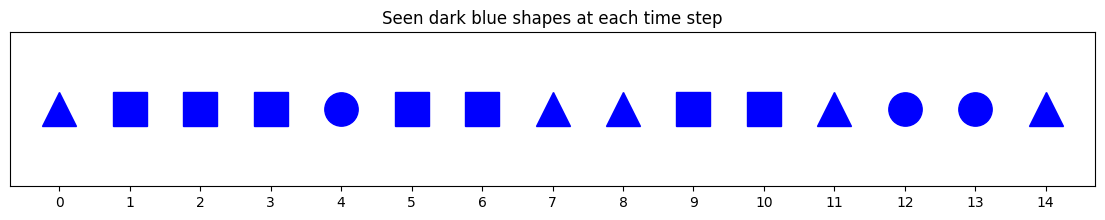

In [9]:
indices_to_shapes = ['s', 'o', '^']
colors = ['blue'] * len(out_indices)

plt.figure(figsize=(14, 2)) 
for i, (shape_index, color) in enumerate(zip(out_indices, colors)):
    plt.plot(i, 1, marker=indices_to_shapes[shape_index], markersize=24, color=color, linestyle='None')

plt.xticks(range(len(out_indices)))
plt.yticks([])
plt.title('Seen dark blue shapes at each time step')
plt.show()

# Belief Propagation

$s_τ$ = $σ(v_τ)$

$\dot v_τ$ = $ε_τ$

## prediction error
$ε_τ$ = $ln(B\overset{\raisebox{0.5ex}{→B}}{µ_{τ-1}} ∘ A ⋅ o_{τ - 1}) + ln(B⋅\overset{←B}{µ_{τ+1}} ∘ A ⋅ o_{τ + 1}) + ln(A ⋅ o_τ) - ln(s_τ)$

$\overset{\raisebox{0.5ex}{→B}}{µ_{τ}}$ = $σ(ln(s_τ) - ln(\overset{\raisebox{0.5ex}{←B}}{µ_{τ}}) - ln(A ⋅ o_τ))$

$\overset{\raisebox{0.5ex}{←B}}{µ_{τ}}$ = $σ(ln(s_τ) - ln(\overset{\raisebox{0.5ex}{→B}}{µ_{τ}}) - ln(A ⋅ o_τ))$

In [10]:
A = [
    light_blue_shapes_os,
    light_green_shapes_os
]

B = [
    light_blue_shapes_ts,
    light_green_shapes_ts
]


D = [
    light_blue_shapes_ps,
    light_green_shapes_ps
]

num_factors = 2

num_iter = 16 # number of iterations of message passing

time_steps = len(outs) # number of time steps

qs_arr = [np.ones((time_steps, len(d))) / len(d) for d in D]
mb_arr = [np.ones((time_steps, len(d))) / len(d) for d in D]
mf_arr = [np.ones((time_steps, len(d))) / len(d) for d in D]

for i, d in enumerate(D):
    mf_arr[i][0] = d

qs_history = [np.zeros((time_steps, num_iter, time_steps, 3)) for _ in range(num_factors)]

tau = 4

for t in range(time_steps):
    for f in range(num_factors):
        for i in range(num_iter):
            for tt in range(time_steps):
                # get the past observation
                if tt - 1 <= t: 
                    log_A_past = log(A[f]) @ outs[tt - 1]
                else:
                    log_A_past = 0

                if tt < t - 1:
                    log_A_future = log(A[f].T) @ outs[tt + 1]
                else:
                    log_A_future = 0

                if tt <= t:
                    log_A = log(A[f].T) @ outs[tt]
                else:
                    log_A = 0

                for ttt in range(time_steps):
                    if ttt <= tt:
                        log_A_t = log(A[f].T) @ outs[ttt]
                    else:
                        log_A_t = 0

                    if ttt <= t and ttt < time_steps:
                        if ttt > 0:
                            # print("in loop")
                            vv = np.exp(log(qs_arr[f][ttt]) - log(mb_arr[f][ttt]) - log_A_t)
                            mf_arr[f][ttt] = vv / np.sum(vv)
                        vv = np.exp(log(qs_arr[f][ttt]) - log(mf_arr[f][ttt]) - log_A_t)
                        mb_arr[f][ttt] = vv / np.sum(vv)

                v = log(qs_arr[f][tt])

                if tt == 0:
                    log_B_past = log(D[f])
                else:
                    log_B_past = log(B[f] @ (mf_arr[f][tt -1] * np.exp(log_A_past)))

                if tt < time_steps - 1:
                    log_A_future = 0 #TODO: log_A_future is never not 0... is this a bug in the original matlab code?
                    log_B_future = log(B[f].T @ (mb_arr[f][tt + 1] * np.exp(log_A_future)))
                else:
                    log_B_future = np.ones_like(D[f])

                v = v + (log_B_past + log_B_future + log_A - v)/tau

                qs_arr[f][tt] = softmax(v)

                qs_history[f][t, i, tt] = qs_arr[f][tt]

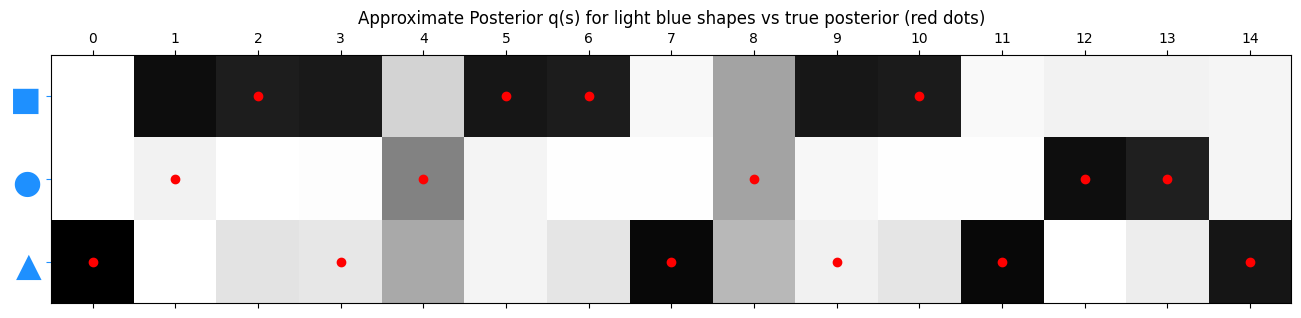

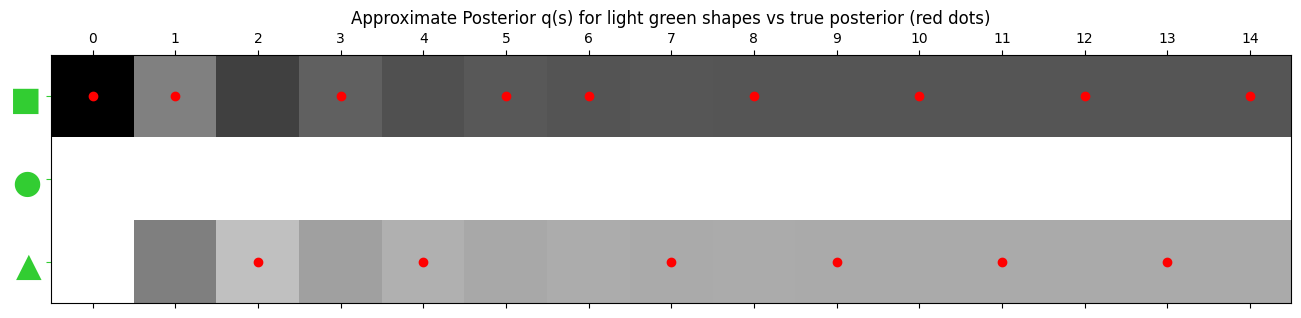

In [11]:
# draw the approximate posteriors for the light blue shapes with the true posterior as red dots
plt.matshow(qs_arr[0].T, vmin = 0.0, vmax = 1.0, cmap='binary')
plt.xticks(range(time_steps))
plt.yticks(range(3),['■', '●', '▲'])
plt.tick_params(axis='y', colors='dodgerblue', labelsize=24)
plt.plot(range(time_steps), light_blue_shapes_true_posterior, 'ro')
plt.title('Approximate Posterior q(s) for light blue shapes vs true posterior (red dots)')
plt.show()
# draw the approximate posteriors for the light green shapes with the true posterior as red dots
plt.matshow(qs_arr[1].T, vmin = 0.0, vmax = 1.0, cmap='binary')
plt.xticks(range(time_steps))
plt.yticks(range(3), ['■', '●', '▲'])
plt.tick_params(axis='y', colors='limegreen', labelsize=24)
plt.plot(range(time_steps), light_green_shapes_true_posterior, 'ro')
plt.title('Approximate Posterior q(s) for light green shapes vs true posterior (red dots)')
plt.show()

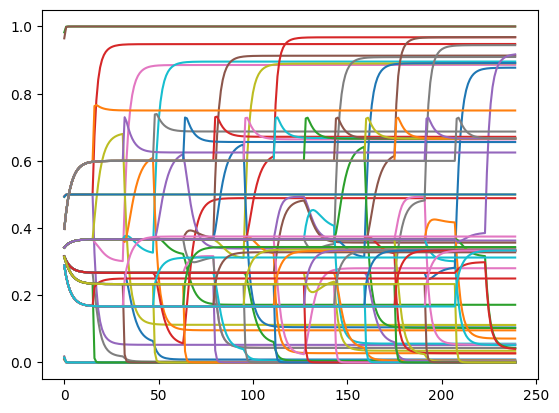

In [12]:
full_beliefs = []
for t in range(time_steps):
    for i in range(num_iter):
        beliefs = []
        for f in range(2):
            beliefs.append(qs_history[f][t][i].flatten())
        beliefs = np.concatenate(beliefs)
        full_beliefs.append(beliefs)

full_beliefs = np.asarray(full_beliefs)
full_beliefs.shape

plt.ylim(-0.05, 1.05)
plt.plot(full_beliefs)
plt.show()

# Variation Message Passing

$s_τ$ = $σ(v_τ)$

$\dot v_τ$ = $ε_τ$

## prediction error
$ε_τ$ = $ln(B)s_{τ - 1} + ln(B) ⋅ s_{τ + 1} + ln(A ⋅ o_τ) - ln(s_τ)$

In [13]:
A = [
    light_blue_shapes_os,
    light_green_shapes_os
]

B = [
    light_blue_shapes_ts,
    light_green_shapes_ts
]


D = [
    light_blue_shapes_ps,
    light_green_shapes_ps
]

num_factors = 2

num_iter = 16 # number of iterations of message passing

time_steps = len(outs) # number of time steps

# qs_arr = np.ones((time_steps, len(D))) / len(D) # array of approximate posteriors q(s) at each time step

qs_arr = [np.ones((time_steps, len(d))) / len(d) for d in D]

qs_history = [np.zeros((time_steps, num_iter, time_steps, 3)) for _ in range(num_factors)]

# for t in range(time_steps):
tau = 4

for t in range(time_steps):
    for f in range(num_factors):
        for i in range(num_iter):
            for tt in range(time_steps):
                if tt <= t:
                    log_A = log(A[f].T)  @ outs[tt]
                else:
                    log_A = 0

                q_s = log(qs_arr[f][tt])

                if tt == 0:
                    log_B_past = log(D[f])
                else:
                    log_B_past = log(B[f]) @ qs_arr[f][tt - 1] 

                if tt == time_steps - 1:
                    log_B_future = 0
                else:
                    log_B_future = log(B[f].T) @ qs_arr[f][tt + 1] #)

                q_s = q_s + (log_B_past + log_B_future + log_A - q_s)/tau

                qs_arr[f][tt] = softmax(q_s)

                qs_history[f][t, i, tt] = qs_arr[f][tt]

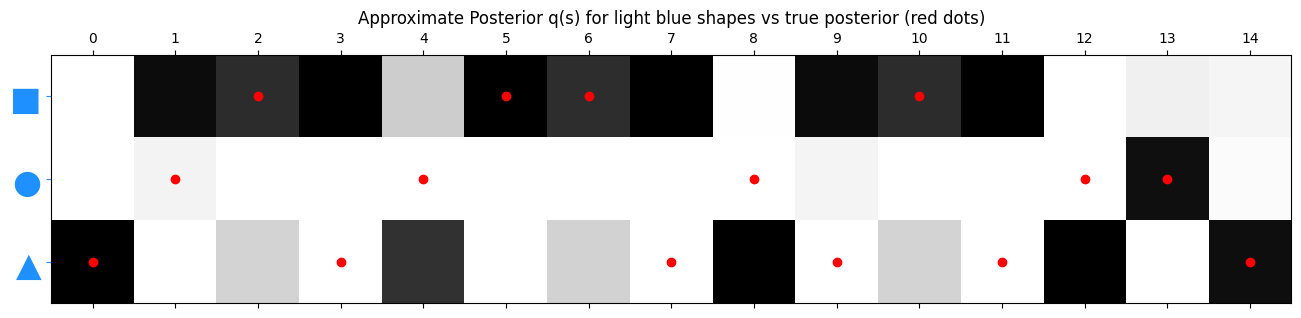

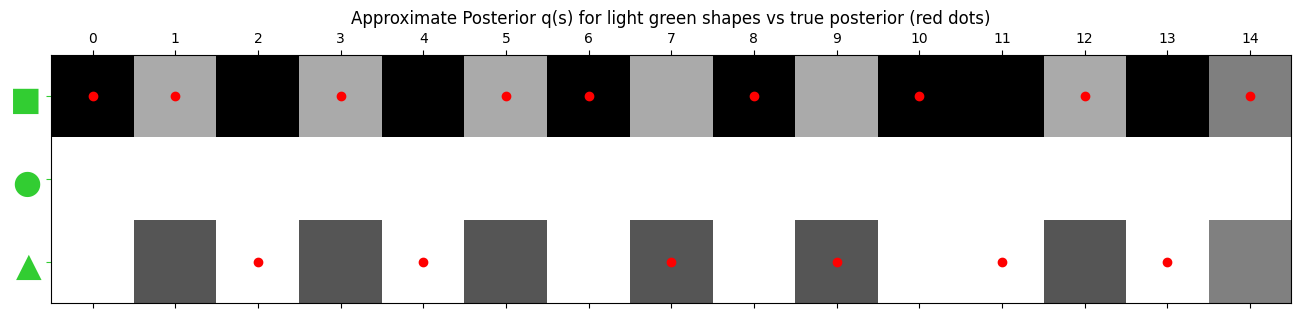

In [14]:
# draw the approximate posteriors for the light blue shapes with the true posterior as red dots
plt.matshow(qs_arr[0].T, vmin = 0.0, vmax = 1.0, cmap='binary')
plt.xticks(range(time_steps))
plt.yticks(range(3),['■', '●', '▲'])
plt.tick_params(axis='y', colors='dodgerblue', labelsize=24)
plt.plot(range(time_steps), light_blue_shapes_true_posterior, 'ro')
plt.title('Approximate Posterior q(s) for light blue shapes vs true posterior (red dots)')
plt.show()
# draw the approximate posteriors for the light green shapes with the true posterior as red dots
plt.matshow(qs_arr[1].T, vmin = 0.0, vmax = 1.0, cmap='binary')
plt.xticks(range(time_steps))
plt.yticks(range(3), ['■', '●', '▲'])
plt.tick_params(axis='y', colors='limegreen', labelsize=24)
plt.plot(range(time_steps), light_green_shapes_true_posterior, 'ro')
plt.title('Approximate Posterior q(s) for light green shapes vs true posterior (red dots)')
plt.show()

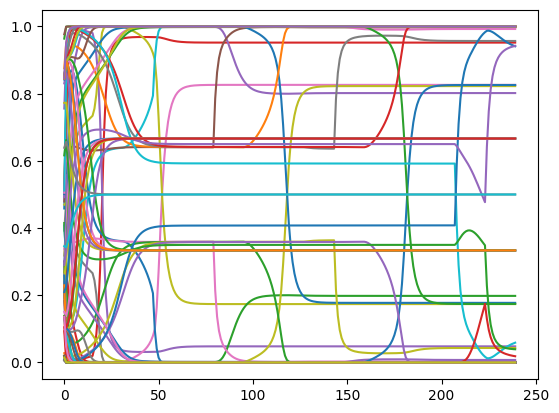

In [15]:
full_beliefs = []
for t in range(time_steps):
    for i in range(num_iter):
        beliefs = []
        for f in range(2):
            beliefs.append(qs_history[f][t][i].flatten())
        beliefs = np.concatenate(beliefs)
        full_beliefs.append(beliefs)

full_beliefs = np.asarray(full_beliefs)
full_beliefs.shape

plt.ylim(-0.05, 1.05)
plt.plot(full_beliefs)
plt.show()

## Marginal Message Passing

$s_τ$ = $σ(v_τ)$

$\dot v_τ$ = $ε_τ$

## prediction error
$ε_τ$ = $\frac{1}{2}(ln(Bs_{τ - 1}) + ln(B^†s_{τ + 1})) + ln(A ⋅ o_τ) - ln(s_τ)$

$B^†$ = $\frac{1}{Z}B^T$

In [17]:
A = [
    light_blue_shapes_os,
    light_green_shapes_os
]

B = [
    light_blue_shapes_ts,
    light_green_shapes_ts
]

# transpose the transition matrices and normalize the columns
B_T = [
    b.T / b.T.sum(axis =0) for b in B 
]

D = [
    light_blue_shapes_ps,
    light_green_shapes_ps
]

num_factors = 2

num_iter = 16 # number of iterations of message passing

time_steps = len(outs) # number of time steps

tau = 4

qs_arr = [np.ones((time_steps, len(d))) / len(d) for d in D] #FIXME: check if fist element should be D

qs_history = [np.zeros((time_steps, num_iter, time_steps, 3)) for _ in range(num_factors)]

# for each time step (over all observations)
for t in range(time_steps):
    # for each factor (light blue shapes, light green shapes)
    for f in range(num_factors):
        # refine the approximate posterior over num_iter iterations
        for i in range(num_iter):
            # for each time step (over all observations)
            for tt in range(time_steps):
                if tt <= t:
                    log_A = log(A[f].T  @ outs[tt] )
                else:
                    log_A = 0
                    
                v = log(qs_arr[f][tt])

                if tt == 0:
                    log_B_past = log(D[f])
                else:
                    log_B_past = log(B[f] @ qs_arr[f][tt - 1])

                if tt == time_steps - 1:
                    log_B_future = 0
                else:
                    log_B_future = log(B_T[f] @ qs_arr[f][tt + 1])
     
                v = v + (0.5 * (log_B_past + log_B_future) + log_A - v)/tau

                qs_arr[f][tt] = softmax(v)

                qs_history[f][t, i, tt] = qs_arr[f][tt]
    


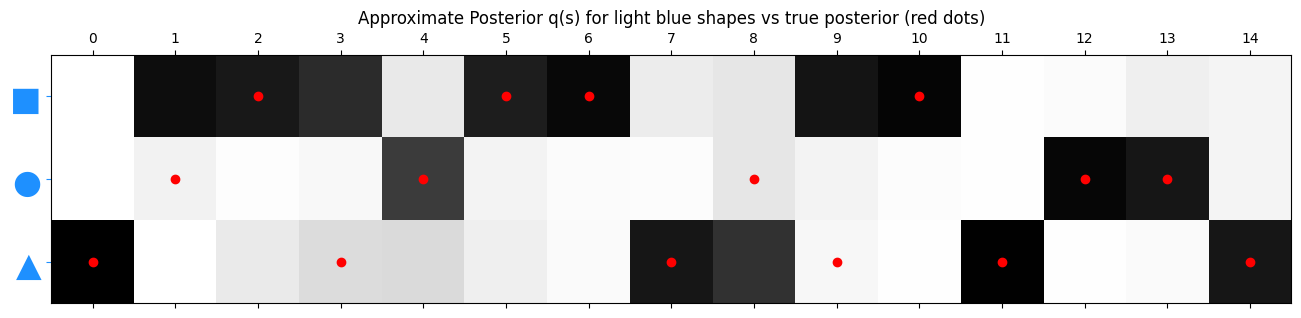

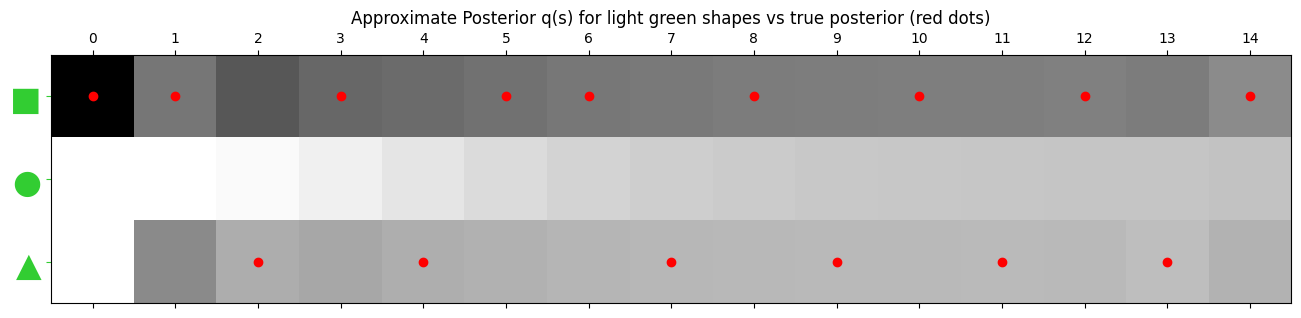

In [17]:
# draw the approximate posteriors for the light blue shapes with the true posterior as red dots
plt.matshow(qs_arr[0].T, vmin = 0.0, vmax = 1.0, cmap='binary')
plt.xticks(range(time_steps))
plt.yticks(range(3),['■', '●', '▲'])
plt.tick_params(axis='y', colors='dodgerblue', labelsize=24)
plt.plot(range(time_steps), light_blue_shapes_true_posterior, 'ro')
plt.title('Approximate Posterior q(s) for light blue shapes vs true posterior (red dots)')
plt.show()
# draw the approximate posteriors for the light green shapes with the true posterior as red dots
plt.matshow(qs_arr[1].T, vmin = 0.0, vmax = 1.0, cmap='binary')
plt.xticks(range(time_steps))
plt.yticks(range(3), ['■', '●', '▲'])
plt.tick_params(axis='y', colors='limegreen', labelsize=24)
plt.plot(range(time_steps), light_green_shapes_true_posterior, 'ro')
plt.title('Approximate Posterior q(s) for light green shapes vs true posterior (red dots)')
plt.show()

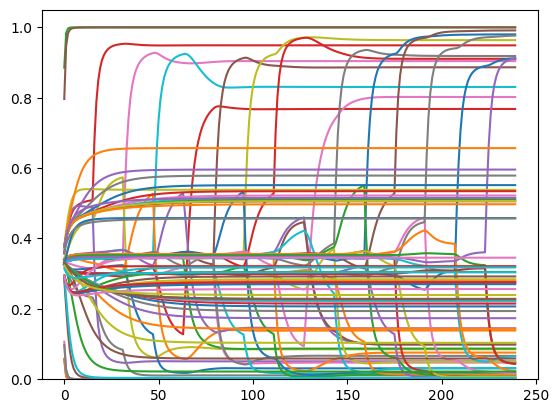

In [18]:
full_beliefs = []
for t in range(time_steps):
    for i in range(num_iter):
        beliefs = []
        for f in range(2):
            beliefs.append(qs_history[f][t][i].flatten())
        beliefs = np.concatenate(beliefs)
        full_beliefs.append(beliefs)

full_beliefs = np.asarray(full_beliefs)
full_beliefs.shape

plt.ylim(0, 1.05)
plt.plot(full_beliefs)
plt.show()

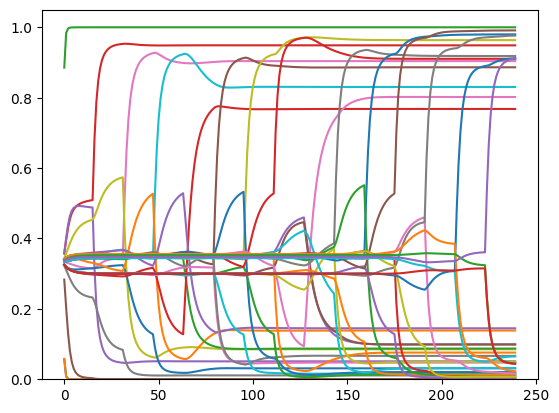

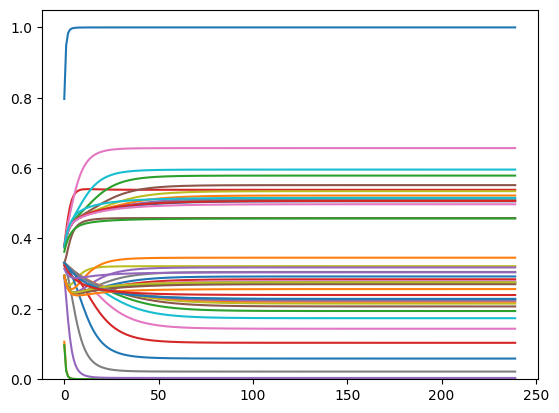

(240, 45)

In [19]:
for f in range(2):
    full_beliefs = []
    for t in range(time_steps):
        for i in range(num_iter):
            # beliefs.append(qs_history[f][t][i].flatten())
            # beliefs = np.concatenate(beliefs)
            full_beliefs.append(qs_history[f][t][i].flatten())
    full_beliefs = np.asarray(full_beliefs)
    plt.plot(full_beliefs)
    plt.ylim(0, 1.05)
    plt.show()

full_beliefs.shape

# plt.plot(full_beliefs)
# plt.show()

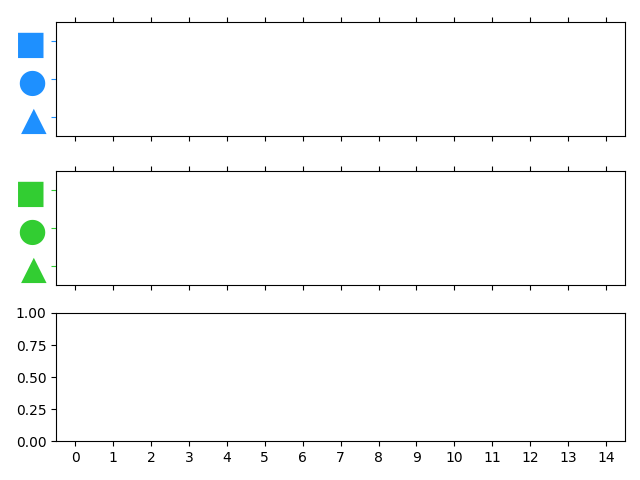

In [20]:
%matplotlib widget
import matplotlib.animation
from matplotlib.patches import Rectangle

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

frames = 1 * time_steps * num_iter

qs_data = np.zeros_like(qs_history[0][0][0].T)

cax1 = ax1.matshow(qs_data, vmin = 0.0, vmax = 1.0, cmap='binary')

# ax1.set_xticks(range(time_steps))
# ax1.set_xticklabels([f'T-{i}' for i in range(time_steps)])  # Explicit labels for bottom axis

ax1.set_yticks(range(3),['■', '●', '▲'])
ax1.tick_params(axis='y', colors='dodgerblue', labelsize=24)

cax2 = ax2.matshow(qs_data, vmin = 0.0, vmax = 1.0, cmap='binary')

ax2.set_xticks(range(time_steps))
ax2.set_xticklabels([f'{i}' for i in range(time_steps)])  # Explicit labels for bottom axis

ax2.set_yticks(range(3),['■', '●', '▲'])
ax2.tick_params(axis='y', colors='limegreen', labelsize=24)

# ax1.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
# ax2.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)

def plot_belief_updating(frame):
    t = (frame // num_iter) % time_steps
    i = frame % num_iter

    cax1.set_data(qs_history[0][t][i].T)
    cax2.set_data(qs_history[1][t][i].T)

    # colors = ['blue'] * len(t) + ['grey'] * (time_steps - len(t))

    current_colors = ["blue" if j <= t else "grey" for j in range(time_steps)]

    for i, (shape_index, color) in enumerate(zip(out_indices, current_colors)):
        plt.plot(i, 1, marker=indices_to_shapes[shape_index], markersize=20, color=color, linestyle='None')

ani = matplotlib.animation.FuncAnimation(fig, plot_belief_updating, frames=frames, interval=200)
plt.tight_layout()
plt.show()

In [21]:
# for f in range(1):
#     full_beliefs = []
#     for t in range(time_steps):
#         # fig, axs = plt.subplots(16)#, figsize=(15, 15))
#         # plt.figure(figsize=(240, 24), dpi=120, sharex=True)
#         # fig, axs = plt.subplots(num_iter, 1, figsize=(240, 24), dpi=120)
#         for i in range(num_iter):
#             # plt.subplot(16, 1, i + 1)
#             plt.matshow(qs_history[f][t][i].T, vmin = 0.0, vmax = 1.0, cmap='binary', fignum=False)
#             plt.yticks(range(3), ['■', '●', '▲'])
#             plt.tick_params(axis='y', colors='dodgerblue')

            
#             # if i == 0:
#             #     ax_top = ax.twiny()
#             #     ax_top.set_xlim(ax.get_xlim())
#             #     ax_top.set_xticks(ax.get_xticks())
#             #     ax_top.set_xticklabels(ax.get_xticklabels())
#             #     ax_top.tick_params(axis='x', direction='in', pad=-15)  # Adjust padding as needed

#         plt.tight_layout()
#         plt.show()

#         break
#     break